In [ ]:
import os
import numpy as np
import pandas as pd
import copy
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    roc_auc_score
)

In [18]:
# Defines a TrypanosomaDataset class, that gets images and labels in order from the dataset
class TrypanosomaDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["filename"]
        label = int(self.df.iloc[idx]["label"])

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label
    
class BCEWithLogitsLossLabelSmoothing(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, logits, targets):
        targets = targets * (1 - self.smoothing) + 0.5 * self.smoothing
        return self.bce(logits, targets)
    
aug_transform = transforms.Compose([
    transforms.Resize((256, 256)),

    # geometrical variations 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.85, 1.15),
        shear=5
    ),

    # microscopy variations / contrast
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.2,
        hue=0.05
    ),

    # changes the field of view
    transforms.RandomResizedCrop(
        size=224,
        scale=(0.7, 1.0)
    ),
])

# Sets seed for everything

def seed_everything(seed=42):
    # Python
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # CuDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # PYTHONHASHSEED
    os.environ["PYTHONHASHSEED"] = str(seed)
# Saves data augmentation example images. Only for visualization

def gerar_dataset_aumentado(df, output_dir, n_aug=3):
    os.makedirs(output_dir, exist_ok=True)

    novos_dados = []

    for _, row in df.iterrows():
        img = Image.open(row["filename"]).convert("RGB")
        label = row["label"]

        base_name = os.path.splitext(os.path.basename(row["filename"]))[0]

        # imagem original
        orig_path = os.path.join(output_dir, f"{base_name}_orig.png")
        img.save(orig_path)
        novos_dados.append((orig_path, label))

        # imagens aumentadas
        for i in range(n_aug):
            aug_img = aug_transform(img)
            aug_path = os.path.join(output_dir, f"{base_name}_aug{i}.png")
            aug_img.save(aug_path)
            novos_dados.append((aug_path, label))

    return pd.DataFrame(novos_dados, columns=["filename", "label"])

# Defines EarlyStop, a function that stops trainig when no improvement is done

class EarlyStopping:
    def __init__(self, patience=7, min_delta=5e-4, enabled=True):
        """
        patience: how many epochs to wait if val accuracy does not improves
        min_delta: the minimum improvement considered to be relevant
        """
        self.patience = patience
        self.min_delta = min_delta
        self.enabled = enabled
        self.best_loss = np.inf
        self.counter = 0
        self.best_state = None
        self.stop = False

    def __call__(self, val_loss, model):
        
        if not self.enabled:
            return
        
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_state = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

# Allows for calculations of accuracy

def binary_accuracy(outputs, labels, threshold=0.4):
    preds = (outputs >= threshold).float()
    correct = (preds == labels).sum().item()
    return correct / labels.numel()

# Creates a test df

def creates_df_test(img_dir, target_file):
    imagens = sorted([
        os.path.join(img_dir, f)
        for f in os.listdir(img_dir)
        if f.endswith(".jpg")
    ],
        key=lambda x: int(os.path.splitext(os.path.basename(x))[0])
)

    labels = np.loadtxt(target_file)

    assert len(imagens) == len(labels), "Number of images ≠ labels"

    return pd.DataFrame({
        "filename": imagens,   
        "label": labels
    })

In [19]:
# Creates a DataFrame with the directory of each image of the dataset and each label IN THE ORIGINAL ORDER

BASE_DIR = r"D:\Andre\Projeto Trypanosoma\trypanosoma_biomed_v4_compatible"
TRAIN_IMG_DIR = os.path.join(BASE_DIR, "train")
VAL_IMG_DIR   = os.path.join(BASE_DIR, "val")

seed_everything(42)

# Lists images in the ORIGINAL ORDER 
train_images = sorted(
    [f for f in os.listdir(TRAIN_IMG_DIR)
     if f.lower().endswith((".png", ".jpg", ".jpeg"))],
    key=lambda x: int(os.path.splitext(x)[0])
)

val_images = sorted(
    [f for f in os.listdir(VAL_IMG_DIR)
     if f.lower().endswith((".png", ".jpg", ".jpeg"))],
    key=lambda x: int(os.path.splitext(x)[0])
)

# Labels (N rows, 1 column)
y_train = np.loadtxt(os.path.join(BASE_DIR, "target_train.txt"))
y_val   = np.loadtxt(os.path.join(BASE_DIR, "target_val.txt"))

# DataFrames 
df_train = pd.DataFrame({
    "filename": [os.path.join(TRAIN_IMG_DIR, f) for f in train_images],
    "label": y_train.astype(int)
})

df_val = pd.DataFrame({
    "filename": [os.path.join(VAL_IMG_DIR, f) for f in val_images],
    "label": y_val.astype(int)
})

print(df_train.head())
print(df_train["label"].value_counts())


                                            filename  label
0  D:\Andre\Projeto Trypanosoma\trypanosoma_biome...      0
1  D:\Andre\Projeto Trypanosoma\trypanosoma_biome...      0
2  D:\Andre\Projeto Trypanosoma\trypanosoma_biome...      1
3  D:\Andre\Projeto Trypanosoma\trypanosoma_biome...      1
4  D:\Andre\Projeto Trypanosoma\trypanosoma_biome...      1
label
1    856
0    816
Name: count, dtype: int64


In [20]:
# DataAugmentation on the fly and Normalization with ImageNet parameters

IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    
    # Geometrical Augmentations 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=5
    ),
    
    # Color/Contrast Augmentations 
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.1,
        hue=0.05
    ),
    
    # Final Crop 
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    
    # ImageNet Normalization 
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])


In [21]:
# DataLoaders

BATCH_SIZE = 16

train_dataset = TrypanosomaDataset(df_train, transform=train_transform)
val_dataset   = TrypanosomaDataset(df_val,   transform=val_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False,
)


In [22]:
# Load Pretrained MobileNetV2, 

from torchvision.models import mobilenet_v2

# Makes the model run in a NVIDIA GPU

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", DEVICE)

# MobileNetV2

model = mobilenet_v2(pretrained=True)
model.classifier = nn.Sequential( # Same classifier used in VGG
    nn.Linear(1280, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(256, 1)
)

# Freeze backbone

for param in model.features.parameters():
    param.requires_grad = False

# Optimizer

optimizer = torch.optim.AdamW(
    model.classifier.parameters(),
    lr=5e-5,
    weight_decay=1e-4
)

# Criterion

criterion = BCEWithLogitsLossLabelSmoothing(smoothing=0.1)

# Scheduler

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=True
)

model = model.to(DEVICE)

Using: cuda


c:\Users\UFRJ\Documents\Andre\Doutorado\Redes Neurais\andre_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\UFRJ\Documents\Andre\Doutorado\Redes Neurais\andre_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


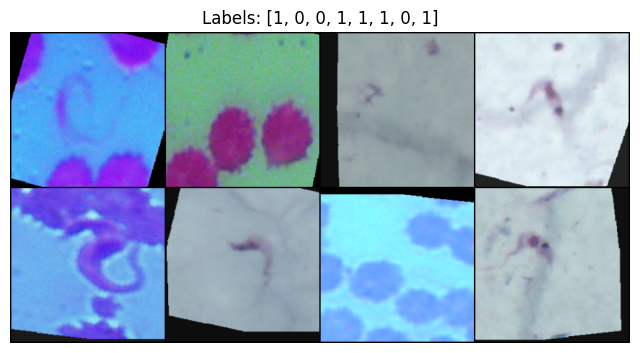

In [7]:
# Visualize the batch that goes to the model. Works for making sure the labels are correct
# Not necessary to run the model

import torchvision

images, labels = next(iter(train_loader))

# desfaz normalização ImageNet
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

images_vis = images.cpu() * std + mean
images_vis = torch.clamp(images_vis, 0, 1)

grid = torchvision.utils.make_grid(images_vis[:8], nrow=4)

plt.figure(figsize=(8,6))
plt.imshow(grid.permute(1,2,0))
plt.title(f"Labels: {labels[:8].tolist()}")
plt.axis("off")
plt.show()


In [23]:
# Train and validation

EPOCHS = 50

best_val_loss = float('inf')
train_losses = []
val_losses = []
early_stopping = EarlyStopping(
    patience=7,
    min_delta=0.001,
    enabled=True  # Turns it on/off
)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 30)

    # Training
    
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for images, labels in tqdm(train_loader):
        images = images.to(DEVICE)
        labels = labels.float().to(DEVICE)

        optimizer.zero_grad()

        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc  += binary_accuracy(outputs.detach(), labels)

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Val

    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE)
            labels = labels.float().to(DEVICE)

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_acc  += binary_accuracy(outputs.detach(), labels)

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    
    # Saves the best model 
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'top_model_MobileNetv2.pth')
        print(f" Model saved. New best val loss: {val_loss:.4f}")
    
    # Scheduler

    scheduler.step(val_loss)

    # Early stop
    
    early_stopping(val_loss, model)
    if early_stopping.stop:
        print("Early stopping triggered")
        break
    print(f"Train loss: {train_loss:.4f}")
    print(f"Val   loss: {val_loss:.4f}")


if early_stopping.best_state is not None:
    model.load_state_dict(early_stopping.best_state)
    print(f"Best val_loss: {early_stopping.best_loss:.4f}")
else:
    print(" Early stopping deactivated - using the last model")


print(f"\n Best Val Loss: {best_val_loss:.4f}")



Epoch 1/50
------------------------------


100%|██████████| 105/105 [00:35<00:00,  2.98it/s]


 Model saved. New best val loss: 0.5674
Train loss: 0.6160
Val   loss: 0.5674

Epoch 2/50
------------------------------


100%|██████████| 105/105 [00:24<00:00,  4.31it/s]


 Model saved. New best val loss: 0.5080
Train loss: 0.4863
Val   loss: 0.5080

Epoch 3/50
------------------------------


100%|██████████| 105/105 [00:23<00:00,  4.54it/s]


 Model saved. New best val loss: 0.4843
Train loss: 0.4606
Val   loss: 0.4843

Epoch 4/50
------------------------------


100%|██████████| 105/105 [00:23<00:00,  4.56it/s]


 Model saved. New best val loss: 0.4753
Train loss: 0.4455
Val   loss: 0.4753

Epoch 5/50
------------------------------


100%|██████████| 105/105 [00:23<00:00,  4.52it/s]


 Model saved. New best val loss: 0.4666
Train loss: 0.4312
Val   loss: 0.4666

Epoch 6/50
------------------------------


100%|██████████| 105/105 [00:22<00:00,  4.61it/s]


 Model saved. New best val loss: 0.4482
Train loss: 0.4146
Val   loss: 0.4482

Epoch 7/50
------------------------------


100%|██████████| 105/105 [00:23<00:00,  4.44it/s]


 Model saved. New best val loss: 0.4433
Train loss: 0.4122
Val   loss: 0.4433

Epoch 8/50
------------------------------


100%|██████████| 105/105 [00:22<00:00,  4.63it/s]


 Model saved. New best val loss: 0.4384
Train loss: 0.4036
Val   loss: 0.4384

Epoch 9/50
------------------------------


100%|██████████| 105/105 [00:23<00:00,  4.47it/s]


 Model saved. New best val loss: 0.4314
Train loss: 0.3982
Val   loss: 0.4314

Epoch 10/50
------------------------------


100%|██████████| 105/105 [00:22<00:00,  4.62it/s]


Train loss: 0.3923
Val   loss: 0.4336

Epoch 11/50
------------------------------


100%|██████████| 105/105 [00:23<00:00,  4.55it/s]


Epoch 00021: reducing learning rate of group 0 to 2.5000e-05.
Train loss: 0.4008
Val   loss: 0.4327

Epoch 12/50
------------------------------


100%|██████████| 105/105 [00:22<00:00,  4.60it/s]


Train loss: 0.3884
Val   loss: 0.4339

Epoch 13/50
------------------------------


100%|██████████| 105/105 [00:24<00:00,  4.36it/s]


 Model saved. New best val loss: 0.4236
Train loss: 0.3845
Val   loss: 0.4236

Epoch 14/50
------------------------------


100%|██████████| 105/105 [00:22<00:00,  4.57it/s]


 Model saved. New best val loss: 0.4166
Train loss: 0.3959
Val   loss: 0.4166

Epoch 15/50
------------------------------


100%|██████████| 105/105 [00:23<00:00,  4.45it/s]


Train loss: 0.3884
Val   loss: 0.4219

Epoch 16/50
------------------------------


100%|██████████| 105/105 [00:22<00:00,  4.62it/s]


Epoch 00031: reducing learning rate of group 0 to 1.2500e-05.
Train loss: 0.3889
Val   loss: 0.4225

Epoch 17/50
------------------------------


100%|██████████| 105/105 [00:23<00:00,  4.46it/s]


Train loss: 0.3985
Val   loss: 0.4248

Epoch 18/50
------------------------------


100%|██████████| 105/105 [00:22<00:00,  4.59it/s]


 Model saved. New best val loss: 0.4162
Train loss: 0.3826
Val   loss: 0.4162

Epoch 19/50
------------------------------


100%|██████████| 105/105 [00:23<00:00,  4.48it/s]


Train loss: 0.3794
Val   loss: 0.4265

Epoch 20/50
------------------------------


100%|██████████| 105/105 [00:22<00:00,  4.60it/s]


Epoch 00039: reducing learning rate of group 0 to 6.2500e-06.
Train loss: 0.3878
Val   loss: 0.4236

Epoch 21/50
------------------------------


100%|██████████| 105/105 [00:23<00:00,  4.39it/s]


 Model saved. New best val loss: 0.4138
Train loss: 0.3831
Val   loss: 0.4138

Epoch 22/50
------------------------------


100%|██████████| 105/105 [00:23<00:00,  4.46it/s]


Train loss: 0.3893
Val   loss: 0.4196

Epoch 23/50
------------------------------


100%|██████████| 105/105 [00:22<00:00,  4.77it/s]


Epoch 00045: reducing learning rate of group 0 to 3.1250e-06.
Train loss: 0.3955
Val   loss: 0.4168

Epoch 24/50
------------------------------


100%|██████████| 105/105 [00:20<00:00,  5.16it/s]


Train loss: 0.3705
Val   loss: 0.4216

Epoch 25/50
------------------------------


100%|██████████| 105/105 [00:21<00:00,  4.88it/s]


Epoch 00049: reducing learning rate of group 0 to 1.5625e-06.
Train loss: 0.3887
Val   loss: 0.4195

Epoch 26/50
------------------------------


100%|██████████| 105/105 [00:20<00:00,  5.12it/s]


Train loss: 0.3823
Val   loss: 0.4223

Epoch 27/50
------------------------------


100%|██████████| 105/105 [00:21<00:00,  4.79it/s]


 Model saved. New best val loss: 0.4136
Train loss: 0.3792
Val   loss: 0.4136

Epoch 28/50
------------------------------


100%|██████████| 105/105 [00:20<00:00,  5.07it/s]


Early stopping triggered
Best val_loss: 0.4138

 Best Val Loss: 0.4136


In [10]:
# K-Fold Validation

K = 5
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df_full = pd.concat([df_train, df_val], ignore_index=True) # Concatenating train and val for 

X = df_full.index.values
y = df_full["label"].values

skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

fold_results = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n===== Fold {fold}/{K} =====")

    train_subset = Subset(
        TrypanosomaDataset(df_full, transform=train_transform),
        train_idx
    )

    val_subset = Subset(
        TrypanosomaDataset(df_full, transform=val_transform),
        val_idx
    )

    train_loader = DataLoader(
        train_subset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0
    )

    val_loader = DataLoader(
        val_subset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0
    )

    EPOCHS = 10
    best_auc = 0.0
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0

        for images, labels in train_loader:
            images = images.to(DEVICE)
            labels = labels.float().to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # ===== Validation =====
        model.eval()
        val_loss = 0.0
        y_true, y_prob = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(DEVICE)
                labels = labels.float().to(DEVICE)

                outputs = model(images).squeeze()
                probs = torch.sigmoid(outputs)

                val_loss += criterion(outputs, labels).item()
                y_true.extend(labels.cpu().numpy())
                y_prob.extend(probs.cpu().numpy())

        val_loss /= len(val_loader)
        val_auc = roc_auc_score(y_true, y_prob)

        print(f"Epoch {epoch+1:02d} | "
              f"Train loss: {train_loss:.4f} | "
              f"Val loss: {val_loss:.4f} | "
              f"AUC: {val_auc:.4f}")

        best_auc = max(best_auc, val_auc)



===== Fold 1/5 =====
Epoch 01 | Train loss: 0.3964 | Val loss: 0.4113 | AUC: 0.9428
Epoch 02 | Train loss: 0.3959 | Val loss: 0.4096 | AUC: 0.9416
Epoch 03 | Train loss: 0.3961 | Val loss: 0.4141 | AUC: 0.9401
Epoch 04 | Train loss: 0.3776 | Val loss: 0.4151 | AUC: 0.9389
Epoch 05 | Train loss: 0.3899 | Val loss: 0.4116 | AUC: 0.9404
Epoch 06 | Train loss: 0.3835 | Val loss: 0.4144 | AUC: 0.9389
Epoch 07 | Train loss: 0.3927 | Val loss: 0.4032 | AUC: 0.9450
Epoch 08 | Train loss: 0.3991 | Val loss: 0.4094 | AUC: 0.9420
Epoch 09 | Train loss: 0.3927 | Val loss: 0.4107 | AUC: 0.9416
Epoch 10 | Train loss: 0.3928 | Val loss: 0.4076 | AUC: 0.9420

===== Fold 2/5 =====
Epoch 01 | Train loss: 0.4007 | Val loss: 0.3498 | AUC: 0.9759
Epoch 02 | Train loss: 0.3922 | Val loss: 0.3482 | AUC: 0.9762
Epoch 03 | Train loss: 0.3972 | Val loss: 0.3467 | AUC: 0.9764
Epoch 04 | Train loss: 0.3974 | Val loss: 0.3438 | AUC: 0.9775
Epoch 05 | Train loss: 0.3951 | Val loss: 0.3435 | AUC: 0.9785
Epoch 06 | 

In [11]:
# Evaluation of the Folds

fold_results.append(best_auc)
print(f"✔️ Best fold AUC {fold}: {best_auc:.4f}")

fold_results = np.array(fold_results)
print("\n===== FINAL Results =====")
print(f"Average AUC (5-fold): {fold_results.mean():.4f}")
print(f"Standard deviation    : {fold_results.std():.4f}")

✔️ Best fold AUC 5: 0.9465

===== FINAL Results =====
Average AUC (5-fold): 0.9465
Standard deviation    : 0.0000


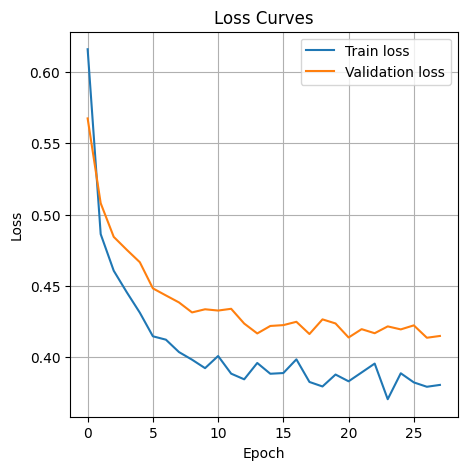

In [24]:
# Plots train and val losses 

plt.figure(figsize=(5,5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Evaluates the training of the model 

model.eval()

y_true = []
y_prob = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images).squeeze()
        probs = torch.sigmoid(outputs)

        y_true.extend(labels.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_prob = np.array(y_prob)


AUC (validação): 0.9410


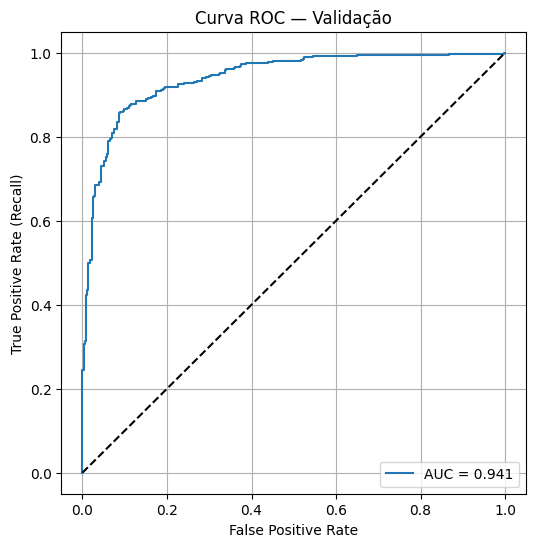

In [26]:
# Validation ROC Curve

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

print(f"AUC (validação): {roc_auc:.4f}")

# Plot
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Curva ROC — Validação")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

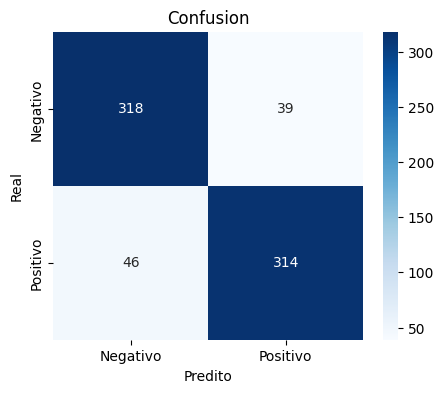

In [27]:
# Confusion Matrix

# Standard threshold
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negativo", "Positivo"],
    yticklabels=["Negativo", "Positivo"]
)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Confusion")
plt.show()


In [28]:
# Creates a test DataFrame woth the images and labels directories 


test_sets = {
    "lamina_18": r"D:\Andre\Projeto Trypanosoma\trypanosoma_biomed_v4_compatible\test\lamina_18\test",
    "lamina_19": r"D:\Andre\Projeto Trypanosoma\trypanosoma_biomed_v4_compatible\test\lamina_19\test",
    "lamina_20": r"D:\Andre\Projeto Trypanosoma\trypanosoma_biomed_v4_compatible\test\lamina_20\test",
    "lamina_23": r"D:\Andre\Projeto Trypanosoma\trypanosoma_biomed_v4_compatible\test\lamina_23\test",
    "lamina_24": r"D:\Andre\Projeto Trypanosoma\trypanosoma_biomed_v4_compatible\test\lamina_24\test",
}

target_files = {
    "lamina_18": r"D:\Andre\Projeto Trypanosoma\trypanosoma_biomed_v4_compatible\test\lamina_18\target_test.txt",
    "lamina_19": r"D:\Andre\Projeto Trypanosoma\trypanosoma_biomed_v4_compatible\test\lamina_19\target_test.txt",
    "lamina_20": r"D:\Andre\Projeto Trypanosoma\trypanosoma_biomed_v4_compatible\test\lamina_20\target_test.txt",
    "lamina_23": r"D:\Andre\Projeto Trypanosoma\trypanosoma_biomed_v4_compatible\test\lamina_23\target_test.txt",
    "lamina_24": r"D:\Andre\Projeto Trypanosoma\trypanosoma_biomed_v4_compatible\test\lamina_24\target_test.txt",
}


In [29]:
 # Tests

# Loads the best model
model.load_state_dict(torch.load('top_model_MobileNetv2.pth'))
model.eval()

for name in test_sets.keys():
    print(f"\n=== Evaluating at {name} ===")

    df_test = creates_df_test(
        img_dir=test_sets[name],
        target_file=target_files[name]
    )

    test_dataset = TrypanosomaDataset(
        df_test,
        transform=val_transform
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=0
    )

    model.eval()

    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images).squeeze()
            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).long()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_pos = tp + fn
    total_neg = tn + fp

    print(f"Acuracy        : {(tp+tn)/(tp+tn+fp+fn):.4f}")
    print(f"Recall (Sens.)  : {tp/(tp+fn):.4f}")
    print(f"Especificidade  : {tn/(tn+fp):.4f}")
    print(f"TP={tp}/{total_pos}, FN={fn}/{total_pos}")
    print(f"TN={tn}/{total_neg}, FP={fp}/{total_neg}")


=== Evaluating at lamina_18 ===
Acuracy        : 0.6594
Recall (Sens.)  : 0.4360
Especificidade  : 0.9189
TP=75/172, FN=97/172
TN=136/148, FP=12/148

=== Evaluating at lamina_19 ===
Acuracy        : 0.8922
Recall (Sens.)  : 0.8966
Especificidade  : 0.8875
TP=78/87, FN=9/87
TN=71/80, FP=9/80

=== Evaluating at lamina_20 ===
Acuracy        : 0.8105
Recall (Sens.)  : 0.7287
Especificidade  : 0.8992
TP=94/129, FN=35/129
TN=107/119, FP=12/119

=== Evaluating at lamina_23 ===
Acuracy        : 0.9609
Recall (Sens.)  : 0.9911
Especificidade  : 0.9322
TP=111/112, FN=1/112
TN=110/118, FP=8/118

=== Evaluating at lamina_24 ===
Acuracy        : 0.9231
Recall (Sens.)  : 0.8821
Especificidade  : 0.9623
TP=404/458, FN=54/458
TN=460/478, FP=18/478
